# Figure 1 (and/or+ Supp Fig) : 

  - exemple of PSD in one subject (displaying 20s epochs)
  - exemple of PSD in one subject (displaying sensors)
  - 1/f for all subjects overlapped in 1 figure (1 line is one subject)
  - psd for all individuals in one or two shots


  - capture and picture variance in figure

We first need to download the requisite data. We are probablt on a "c3.2xlarge" instance, where the storage dir is in /mnt by my own convention.
We also make sure that all auxilliary files are in our working directory.
Depending on the kind of instance this type of downloading can take a moment. Might be worth having a coffee.

In [12]:
%%bash
(cp ../*txt . && cp ../*csv .)

In [6]:
%%bash
for sub in $(cat hcp_good_subjects.txt); do
    echo "downloading epochs for ${sub}" 
    python hcp_compute_subject.py --storage_dir /mnt --hcp_no_anat --hcp_no_meg \
    --subject $sub --downloaders "library:downloaders.get_single_trial_psd";
done

Elapsed time downloading hcp-meg-data from s3 00:00:10
generating results dir
generated run id: 2016-04-27_14-28-53
preparing logging:
... making logging directory: /mnt/hcp-meg/100307/download_only/2016-04-27_14-28-53
... writing runtime info to: /mnt/hcp-meg/100307/download_only/2016-04-27_14-28-53/run_time.json
... logging source code of calling script
... No config found. Logging nothing.
... preparing Report
Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css
... setting logfile: /mnt/hcp-meg/100307/download_only/2016-04-27_14-28-53/run_output.log
calling "download_only./home/ubuntu/github/meg_study_dynamic_scales/scripts/hcp_compute_subject" with:
	subject: 100307
downloading only
Elapsed time for running scripts 00:00:10
could not get hcp-meg/102816/psds-r0-0-150-epo.fif : it does not exist
could not get hcp-meg/102816/psds-r1-0-150-epo.fif : it does not exist
could not get hcp-meg

# Now that we have downloaded everything let's get the stuff into Python.

- What we then need to do in order to get the figures is to first compute grand averages and grand standard deviations per subject. 
- Then we can pick good examples of individual subjects. 
- Then we can compute total grand averages total grand standard deviation.
- Then we can look into 1/f stuff

In [44]:
import glob
import os.path as op
recordings_path = '/mnt/hcp-meg'
pattern = 'psds-r{run}-0-150-epo.fif'
subjects = glob.glob(op.join(hcp_path, '??????'))

def get_epochs_for_subject(subject):
    epochs_list = list()
    for run_index in range(2):
        psd_fname = op.join(recordings_path, subject, pattern.format(run=run_index))
        if op.isfile(psd_fname):
            epochs = mne.read_epochs(psd_fname)
            if epochs.info['nchan'] == 248:
                epochs_list.append(epochs)
    if epochs_list:
        epochs = mne.epochs.concatenate_epochs(epochs_list)
    else:
        epochs = None
    return epochs

# mean first or log first?

In [81]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

epochs = get_epochs_for_subject(subjects[0])
X_std = np.log10(epochs.standard_error().data)
X2_std = np.log10(epochs.get_data()).std(0)
X = np.log10(epochs.average().data)
X2 = np.log10(epochs.get_data()).mean(0)

# multitaper does subsample, our actual frange is:
freqs = np.log10(np.linspace(0.001, 127, len(epochs.times)))

Reading /mnt/hcp-meg/250427/psds-r0-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
12 matching events found
No baseline correction applied
12 matching events found
No baseline correction applied
0 projection items activated
Reading /mnt/hcp-meg/250427/psds-r1-0-150-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   14997.22 ms (None)
        0 CTF compensation matrices available
56 matching events found
No baseline correction applied
56 matching events found
No baseline correction applied
0 projection items activated
68 matching events found
No baseline correction applied
0 bad epochs dropped


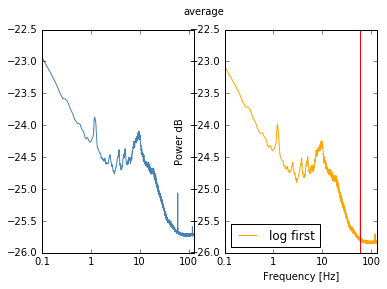

In [86]:
fig, axes = plt.subplots(1, 2, sharex=True)
plt.suptitle('average')
axes[0].plot(freqs, X.mean(0), color='steelblue', label='average first')
axes[1].plot(freqs, X2.mean(0), color='orange', label='log first')
plt.axvline(np.log10(60), color='red')
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 130]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power dB')
plt.legend(loc='lower left')

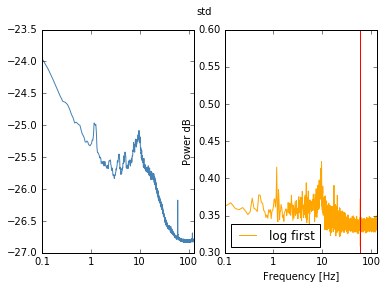

In [88]:
fig, axes = plt.subplots(1, 2, sharex=True)
plt.suptitle('std')
freqs = np.log10(np.linspace(0.001, 127, len(epochs.times)))
axes[0].plot(freqs, X_std.mean(0), color='steelblue', label='average first')
axes[1].plot(freqs, X2_std.mean(0), color='orange', label='log first')
plt.axvline(np.log10(60), color='red')
plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])
plt.xlim(np.log10([0.1, 130]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power dB')
plt.legend(loc='lower left')

In [ ]:
%%bash

git add plot_figures_one.ipynb
git ci -am 'notebook updates'
git push origin master